<a href="https://colab.research.google.com/github/Yuan-Chun-Chih/HW_4_10_23/blob/main/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
import requests
from bs4 import BeautifulSoup
import re
import jieba
import jieba.posseg as pseg
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")
/usr/local/lib/python3.12/dist-packages/jieba/posseg/__init__.py:16: SyntaxWarning: invalid escape sequence '\.'
  re_skip_detail = re.compile("([\.0-9]+|[a-zA-Z0-9]+)")
/usr/local/lib/python3.12/dist-packages/jieba/posseg/__init__.py:17: SyntaxWarning: invalid escape sequence '\.'
  re_han_internal = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._]+)")
/usr/local/lib/python3.12/dist-packages/jieba/posseg/__init__.py:18: SyntaxWarning: invalid escape sequence '\s'
  re_skip_internal = re.compil

In [ ]:
# ===============================
# 一、設定參數
# ===============================
BASE_URL = "https://theygopedia.blogspot.com/"
PAGES_TO_FETCH = 3   # 想抓取的頁數，這裡先抓 3 頁做測試
stopwords = set(['的','了','是','在','我','你','他','她','之','一個','和','分享','討論','文章','本站'])

articles_data = []

In [ ]:
# ===============================
# 二、執行爬蟲
# ===============================
for page in range(1, PAGES_TO_FETCH + 1):
    if page == 1:
        url = BASE_URL
    else:
        # 注意：Blogger 頁面分頁方式可能以「/search?&max-results=20&start=X」為主
        url = f"{BASE_URL}search?&max-results=20&start={(page-1)*20}"
    print(f"Fetching page {page} … URL: {url}")
    resp = requests.get(url, timeout=10, headers={'User-Agent':'Mozilla/5.0'})
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')
    # 標題與連結通常在 <h3 class="post-title"><a href="…">標題</a></h3>
    for tag in soup.select("h3.post-title > a"):
        title = tag.text.strip()
        href = tag['href']
        # 取得日期（常在前一個或兄弟節點中有 .date-header）
        date_tag = tag.find_previous("h2", class_="date-header")
        date = date_tag.text.strip() if date_tag else ""
        articles_data.append({
            'title': title,
            'date': date,
            'href': href
        })

print(f"\n共蒐集文章數量: {len(articles_data)}")


Fetching page 1 … URL: https://theygopedia.blogspot.com/
Fetching page 2 … URL: https://theygopedia.blogspot.com/search?&max-results=20&start=20
Fetching page 3 … URL: https://theygopedia.blogspot.com/search?&max-results=20&start=40

共蒐集文章數量: 61


In [ ]:
# ===============================
# 三、儲存資料
# ===============================
df = pd.DataFrame(articles_data)
df.to_csv("theygopedia_articles.csv", index=False, encoding="utf-8-sig")
print("已輸出 CSV 檔案。")

# 顯示前 10 筆範例
print("\n--- 前 10 筆文章資料 ---")
print(df.head(10))


已輸出 CSV 檔案。

--- 前 10 筆文章資料 ---
                                               title date  \
0                                           【常用資料】索引        
1  【主題卡組】 「王家的神殿」牌組介紹（王家の神殿｜Temple of the Kings｜王...        
2       【主題卡組】 「殺手旋律」牌組介紹（ キラーチューン｜Killer Tune｜杀手旋律）        
3           【主題卡組】 「百臂無形」牌組介紹（ 見えざる手｜HECAHANDS｜百臂无形）        
4                                         【潮落牌坊】觸裝神社        
5                   【主題牌組】「寶箱屍鬼」牌組介紹（ミミグル｜Mimighoul）        
6                  【主題牌組】「白骨」牌組介紹（ワイト｜Skull Servant）        
7             【主題牌組】「末那喜」牌組介紹（マナドゥム｜Mannadium｜玛那桃圆乡）        
8               【主題牌組】「巨石遺物」牌組介紹（メガリス｜Megalith｜巨石异物）        
9  【常用資料】「巨石遺物」COMBO整理（メガリスの展開｜Megalith Combo｜巨石异...        

                                                href  
0  https://theygopedia.blogspot.com/2020/06/index...  
1  https://theygopedia.blogspot.com/2025/10/templ...  
2  https://theygopedia.blogspot.com/2025/10/kille...  
3  https://theygopedia.blogspot.com/2025/10/hecah...  
4  https://theygopedi

In [ ]:
# ===============================
# 四、中文分詞 + 詞頻統計
# ===============================
word_counts = Counter()
for title in df['title']:
    cleaned = re.sub(r'[^\w\s]', '', title)  # 移除標點
    words = jieba.cut(cleaned, cut_all=False)
    for w in words:
        w = w.strip()
        if len(w) > 1 and w not in stopwords:
            word_counts[w] += 1

print("\n--- 詞頻統計（前 10 名）---")
for word, count in word_counts.most_common(10):
    print(f"'{word}': {count} 次")


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.228 seconds.
DEBUG:jieba:Loading model cost 1.228 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.



--- 詞頻統計（前 10 名）---
'主題': 42 次
'組介紹': 39 次
'牌組': 18 次
'巨石': 12 次
'卡組': 9 次
'王家': 9 次
'神殿': 9 次
'天威': 9 次
'千年': 9 次
'常用': 7 次


In [ ]:
# ===============================
# 五、TF-IDF 關鍵詞分析
# ===============================
documents = []
for title in df['title']:
    cleaned = re.sub(r'[^\w\s]', '', title)
    words = jieba.lcut(cleaned, cut_all=False)
    filtered = [w for w in words if len(w) > 1 and w not in stopwords]
    documents.append(" ".join(filtered))

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

avg_tfidf = defaultdict(float)
for row in tfidf_matrix.toarray():
    for idx, weight in enumerate(row):
        avg_tfidf[feature_names[idx]] += weight
for w in avg_tfidf:
    avg_tfidf[w] /= len(documents)

sorted_tfidf = sorted(avg_tfidf.items(), key=lambda item: item[1], reverse=True)
print("\n--- TF-IDF 前 10 名 ---")
for w, score in sorted_tfidf[:10]:
    print(f"'{w}': {score:.4f}")


--- TF-IDF 前 10 名 ---
'主題': 0.1080
'組介紹': 0.1032
'牌組': 0.0768
'巨石': 0.0554
'天威': 0.0453
'deck': 0.0426
'潮落': 0.0424
'牌坊': 0.0424
'punk': 0.0415
'千年': 0.0409


In [ ]:
# Install a Chinese font
!apt-get update
!apt-get install -y fonts-wqy-zenhei
!fc-cache -fv
!rm -rf /var/cache/apt/*

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,086 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38364 (\N{CJK UNIFIED IDEOGRAPH-95DC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37749 (\N{CJK UNIFIED IDEOGRAPH-9375}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35422 (\N{CJK UNIFIED IDEOGRAPH-8A5E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38642 (\N{CJK UNIFIED IDEOGRAPH-96F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


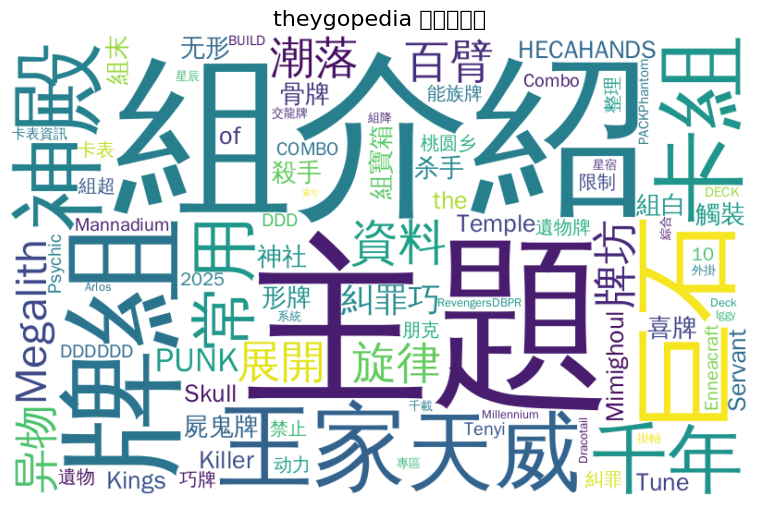

In [ ]:
# ===============================
# 六、詞雲視覺化
# ===============================
wc = WordCloud(
    font_path="/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc",  # Use the installed font
    background_color="white",
    width=800,
    height=500,
    max_words=150
)
wc.generate_from_frequencies(word_counts)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("theygopedia 關鍵詞詞雲", fontsize=16)
plt.show()